In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
from glob2 import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_dir = 'dataset/nomal_data/train'
test_dir = 'dataset/nomal_data/test'
an_dir = 'data2/anomal_data/'
image_size = (200, 200)
batch_size = 64

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              color_mode='grayscale',
                                              class_mode='input')

test_gen = test_datagen.flow_from_directory(test_dir,
                                            target_size=image_size,
                                            batch_size=batch_size,
                                            color_mode='grayscale',
                                            class_mode='input')

an_gen = test_datagen.flow_from_directory(an_dir,
                                          target_size=image_size,
                                          batch_size=batch_size,
                                          color_mode='grayscale',
                                          class_mode='input')

Found 8064 images belonging to 1 classes.
Found 1008 images belonging to 1 classes.
Found 322 images belonging to 1 classes.


In [5]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(40000, activation='sigmoid'),
            layers.Reshape((200, 200, 1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()

In [6]:
autoencoder = Autoencoder()
autoencoder.compile(optimizer='SGD', loss='mse')

checkpoint_path = "./checkpoint/cp.ckpt"

autoencoder.load_weights(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

autoencoder.fit(train_gen,
                epochs=1,
                shuffle=True,
                validation_data=test_gen,
                callbacks=[cp_callback])

125/126 [============================>.] - ETA: 0s - loss: 0.0455- ETA: 1s - l
Epoch 00001: saving model to ./checkpoint\cp.ckpt
126/126 [==============================] - 7s 56ms/step - loss: 0.0455 - val_loss: 0.0515


In [7]:
checkpoint_path = "./checkpoint/cp.ckpt"
autoencoder.load_weights(checkpoint_path)

In [8]:
def show_img(xs, decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(xs[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

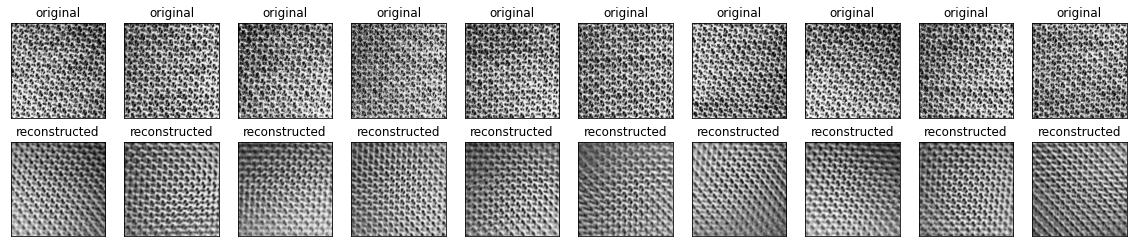

In [9]:
xs, ys = next(train_gen)
encoded_imgs = autoencoder.encoder(xs).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
show_img(xs, decoded_imgs)

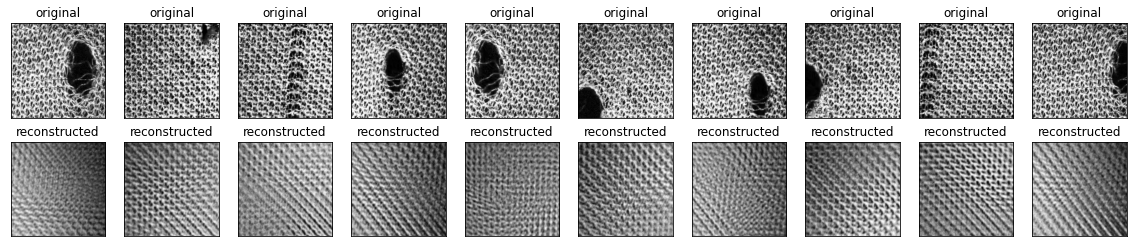

In [10]:
xs, ys = next(an_gen)
encoded_imgs = autoencoder.encoder(xs).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
show_img(xs, decoded_imgs)

In [11]:
def mse_losses(gen, batch_size):
    losses = []
    num = gen.samples
    for i, (xs, ys) in enumerate(gen):
        if i > num//batch_size:
            break
        res = autoencoder.predict(xs)
        for r, x in zip(res, xs):
            losses.append((np.square(r - x)).mean())
    return losses

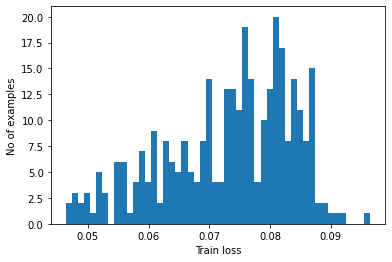

In [12]:
losses = mse_losses(an_gen, batch_size)

plt.hist(losses, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

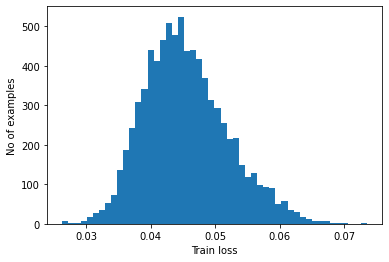

In [13]:
train_loss = mse_losses(train_gen, batch_size)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

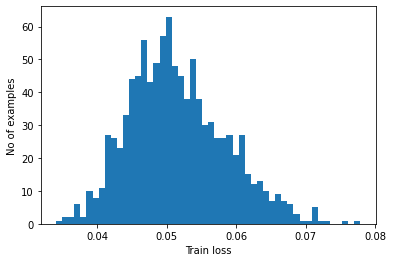

In [25]:
test_loss = mse_losses(test_gen, batch_size)

plt.hist(test_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [58]:
threshold = 0.06

In [59]:
losses = np.array(losses)
np.count_nonzero(losses >= threshold) / len(losses)

0.8571428571428571

In [60]:
train_loss = np.array(train_loss)
np.count_nonzero(train_loss <= threshold) / len(train_loss)

0.9765009842519685

In [61]:
test_loss = np.array(test_loss)
np.count_nonzero(test_loss <= threshold) / len(test_loss)

0.8720238095238095